<a href="https://colab.research.google.com/github/Abhijit-2592/visualizing_cnns/blob/master/occlusion_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Occlusion experiments

This is one of the most straight forward and the most intuitive way of visualizing whether the network has learnt the corresponding class properly. The idea is pretty simple: Suppose we have a dog image and the network says with good confidence that this image contains **dog**. How can we verify that the network is looking at the portion of the image that contains the dog to classify it? The most intuitive way is to occlude the parts of image containing the **dog** and to see if the classification scores plummets. This simple idea is presented in this notebook.

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import cv2

In [0]:
%matplotlib inline

In [0]:
print(cv2.__version__)
print(tf.__version__)
print(np.__version__)

4.1.2
2.1.0
1.17.5


In [0]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

553467904/553467096 [==============================] - 6s 0us/step


In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

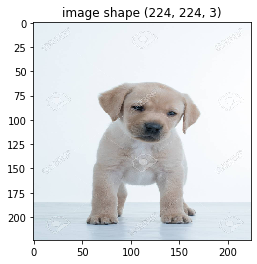

In [0]:
image = np.array(tf.keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.title("image shape {}".format(image.shape))
plt.imshow(image)
plt.show()

In [0]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

In [0]:
preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image.astype(np.float32))
input_image = np.expand_dims(preprocessed_image, axis=0)  # Needs to be of shape (1, 224, 244, 3)
print(input_image.shape)

(1, 224, 224, 3)


In [0]:
predictions = np.squeeze(model.predict(input_image))
prediction_index = np.argmax(predictions)
print(prediction_index)
prediction_class = labelmap[str(prediction_index)]
prediction_score = predictions[prediction_index]

print("Prediction: {}\nConfidence score: {}".format(prediction_class, prediction_score))

208
Prediction: Labrador_retriever
Confidence score: 0.8929277658462524


# Slide a mask along the image

In [0]:
mask_size=50
masked_images = []
for i in range(0, image.shape[0], int(mask_size/2)):
    for j in range(0, image.shape[1], int(mask_size/2)):
        masked_image = image.copy()
        masked_image[i: i + mask_size, j: j + mask_size, :] = 0
        masked_images.append(masked_image)

In [0]:
len(masked_images)

81

In [0]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(np.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images

In [0]:
image_size = (int(np.sqrt(len(masked_images))), int(np.sqrt(len(masked_images))))
print(image_size)

(9, 9)


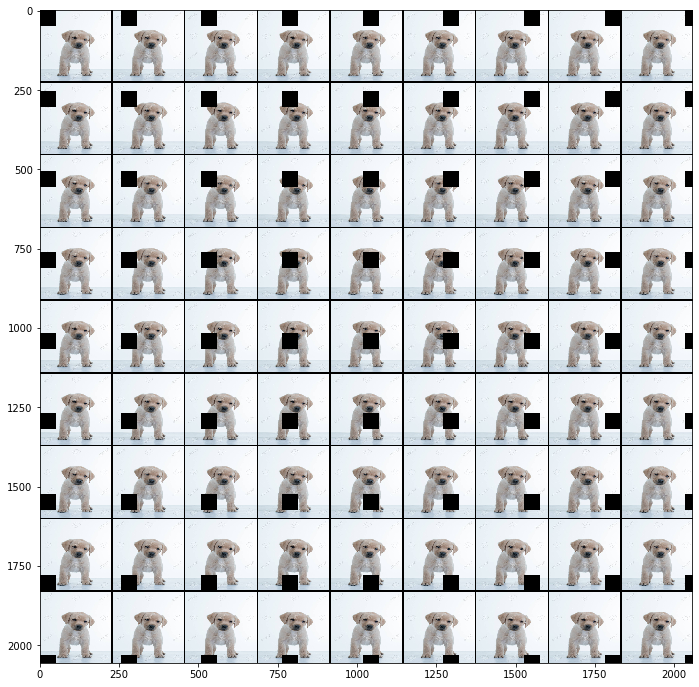

In [0]:
stitched_image = stitch_images(masked_images,cols=image_size[0])
plt.figure(figsize=(12,12))
plt.imshow(stitched_image)
plt.show()

In [0]:
def preprocess_image(img):
    img = tf.keras.applications.vgg16.preprocess_input(img.astype(np.float32))
    return np.expand_dims(img, axis=0)

In [0]:
scores = []
progbar = tf.keras.utils.Progbar(len(masked_images))
for i,img in enumerate(masked_images):
    img = preprocess_image(img)
    predictions = np.squeeze(model.predict(img))
    scores.append(predictions[np.argmax(predictions)])
    progbar.update(i+1)

81/81 [==============================] - 48s 589ms/step


In [0]:
scores = np.array(scores).reshape(image_size)

In [0]:
np.set_printoptions(linewidth=200)  # for printing numpy array properly
print(scores)
print(scores.shape)

[[0.9112552  0.9071986  0.8987363  0.87498164 0.88173515 0.9234559  0.92631453 0.9278904  0.9106187 ]
 [0.8999357  0.87560624 0.52197784 0.40377265 0.23097177 0.816761   0.83232284 0.92310137 0.9030789 ]
 [0.8797684  0.73711604 0.40837282 0.13148016 0.16595294 0.5514183  0.7317057  0.88148767 0.90794706]
 [0.88246256 0.8250613  0.4146164  0.34763572 0.19764712 0.3382793  0.7208828  0.84785444 0.90188545]
 [0.8921871  0.82646906 0.72871363 0.76832265 0.5605426  0.6957939  0.7784785  0.9052648  0.89477915]
 [0.89168245 0.81966996 0.7843838  0.7326889  0.90305394 0.76733696 0.89239293 0.890715   0.88877606]
 [0.88220835 0.71325725 0.70374936 0.66837794 0.7857916  0.8778872  0.89646226 0.87959    0.8868473 ]
 [0.8826143  0.7914077  0.8256122  0.79958045 0.88933057 0.89050615 0.9137739  0.89607185 0.89716536]
 [0.89499706 0.768066   0.82158387 0.8362575  0.89476156 0.890183   0.88124055 0.88596445 0.8917171 ]]
(9, 9)


# Convert scores to Heatmap

In [0]:
heatmap = cv2.resize(scores, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)  # OpenCV is in BGR

In [0]:
def overlay(array1, array2, alpha=0.5):
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [0]:
superimposed_img = overlay(heatmap, image)

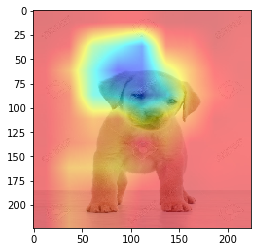

In [0]:
plt.imshow(superimposed_img)
plt.show()

As expected! The heatmap shows that the classification score plummets when we cover the face of the dog. So this gives some evidence that the network is looking at the right parts of the image for classifying that this is a **labrador**